In [8]:
# Cell 1: Import necessary libraries
import matplotlib.pyplot as plt  # For plotting data
import numpy as np  # For numerical operations
import cv2  # For image processing
from tqdm import trange  # For displaying progress bars in loops
from gymnasium.utils.env_checker import check_env  # For checking simulation environments
from flygym import Fly, Camera  # For creating fly agents and cameras in simulations
from flygym.arena import FlatTerrain, OdorArena  # For creating terrains and arenas in simulations
from flygym.examples.turning_controller import HybridTurningNMF  # For implementing a neural-muscular turning controller
from pathlib import Path  # For handling file paths

# Cell 2: Define parameters
Path("./outputs/outputs_finaux").mkdir(exist_ok=True)  # Ensure the output directory exists

# Define the peak odor intensity and source position
peak_odor_intensity = np.array([[1, 0]])
odor_source_A = np.array([[-8, 1, 0.2]])
marker_colors = [[255, 127, 14]]
marker_colors = np.array([[*np.array(color) / 255, 1] for color in marker_colors])  # Convert RGB to normalized RGBA

# Setup the simulation arena
arena = OdorArena(
    odor_source=odor_source_A,
    peak_odor_intensity=peak_odor_intensity,
    diffuse_func=lambda x: x**-2,  # Diffusion function for odor spread
    marker_colors=marker_colors,
    marker_size=0.3
)

# Cell 5: Setup the fly and camera
contact_sensor_placements = [f"{leg}{segment}" for leg in ["LF", "LM", "LH", "RF", "RM", "RH"] for segment in ["Tibia", "Tarsus1", "Tarsus2", "Tarsus3", "Tarsus4", "Tarsus5"]]
fly = Fly(
    spawn_pos=(0, -1, 0.2),
    spawn_orientation=(0, 0, np.pi),  # Orient the fly facing left
    contact_sensor_placements=contact_sensor_placements,
    enable_olfaction=True,
    enable_adhesion=True,
    draw_adhesion=False
)

cam = Camera(
    fly=fly,
    camera_id="birdeye_cam",
    play_speed=0.2,
    window_size=(1000, 608)
)

sim = HybridTurningNMF(
    fly=fly,
    cameras=[cam],
    arena=arena
)

# Simulation parameters
global white_area_bounds, attractive_gain, aversive_gain, decision_interval, run_time, num_decision_steps, physics_steps_per_decision_step, speed, curr_time, initial_xpos, n_delays
odor_dimensions = len(peak_odor_intensity[0])
white_area_bounds = [[0,0],[0,0]]  # Initial bounds for monitoring
attractive_gain = -500
aversive_gain = 500
decision_interval = 0.05
run_time = 5
num_decision_steps = int(run_time / decision_interval)
physics_steps_per_decision_step = int(decision_interval / sim.timestep)
speed = 5
curr_time = 0
initial_xpos = odor_source_A[0][0]
n_delays = 10

# Cell 3: Define utility functions
def draw_white_area_corners(frame, bounds, color=(0, 0, 255), size=5):
    """ Draw corners of a designated 'white area' on the frame for visualization. """
    x1, y1 = bounds[0]
    x2, y2 = bounds[1]
    corners = [(x1, y1), (x1, y2), (x2, y1), (x2, y2)]
    for corner in corners:
        pixel_x = int((corner[0] + 6.75) * 100)  # Scaling position to pixel values
        pixel_y = int((corner[1] - 0.46) * 100)
        cv2.circle(frame, (pixel_x, pixel_y), size, color, -1)
    return frame

def is_in_white_area(position, bounds):
    """ Check if a given position is within the designated 'white area'. """
    x, y = position[:2]
    x1, y1 = bounds[0]
    x2, y2 = bounds[1]
    return x1 <= x <= x2 and y1 <= y <= y2

# Cell 7: Function to run the simulation
def run_simulation(fly_mobile=True, source_mobile=False, bounds=False, white_area_bounds=white_area_bounds, bounds_speed=np.array([[0.03, 0.0], [0.03, 0.0]]), n_delays=n_delays):
    """ Conducts the simulation with configured parameters. """
    global curr_time, initial_xpos, x_positions, times, obs_hist, odor_history, antennae_positions, O, HRC_model
    x_positions = []
    times = []
    obs_hist = []
    odor_history = []
    antennae_positions = []
    delayed_intensities = []
    obs, _ = sim.reset()  # Reset the simulation to start fresh.

    for i in trange(num_decision_steps):
        antennae_pos = sim.physics.bind(fly._antennae_sensors).sensordata
        antennae_pos = antennae_pos.reshape(-1, 3)  # Reformat sensor data for processing.
        antennae_positions.append(antennae_pos)
        if bounds:  # Adjust odor intensity based on position within bounds.
            white_area_bounds += bounds_speed
            odor_intensity = arena.get_olfaction(antennae_pos)
            for idx, sensor_pos in enumerate(antennae_pos):
                if not is_in_white_area(sensor_pos, white_area_bounds):
                    odor_intensity[:, idx] = 0
                    obs["odor_intensity"] = odor_intensity.astype(np.float32)

        attractive_intensities = np.average(
            obs["odor_intensity"][0, :].reshape(2, 2), axis=0, weights=[9, 1]
        )
        aversive_intensities = np.average(
            obs["odor_intensity"][1, :].reshape(2, 2), axis=0, weights=[10, 0]
        )

        control_signal = np.zeros((2,))

        delayed_intensities = O.pop(0)
        current_intensities = [obs["odor_intensity"][0, :][1], obs["odor_intensity"][0, :][3]]
        O.append(current_intensities)
        HRC_model.append(delayed_intensities[0] * current_intensities[1] - delayed_intensities[1] * current_intensities[0])

        odor_history.append(attractive_intensities + aversive_intensities)
        if source_mobile:
            xpos += 0.03
        if bounds:
            xposA += 0.03
            xposB += 0.03

        for j in range(physics_steps_per_decision_step):
            curr_time += sim.timestep
            times.append(curr_time)
            x_positions.append(xpos)

            if source_mobile:
                sim.physics.bind(marker).mocap_pos[:2] = [xpos, 1]
                arena.odor_source[0, :2] = [xpos, 1]
            if bounds:
                sim.physics.bind(markerA).mocap_pos[:2] = [xposA, -5]
                arena.odor_source[1, :2] = [xposA, -5]
                sim.physics.bind(markerB).mocap_pos[:2] = [xposB, 5]
                arena.odor_source[2, :2] = [xposB, 5]

            obs, _, _, _, _ = sim.step(control_signal)
            rendered_img = sim.render()[0]
            if rendered_img is not None:
                hrc_value = HRC_model[-1] if HRC_model else 0
                im = cv2.putText(
                    rendered_img,
                    f"HRC Model: {hrc_value:.8f}",
                    (100, 50),
                    cv2.FONT_HERSHEY_SIMPLEX,
                    1,
                    (0, 0, 0),
                    2,
                    cv2.LINE_AA
                )
                cam._frames[-1] = im

            obs_hist.append(obs)



In [9]:

run_simulation(fly_mobile=False, source_mobile=True,bounds=False)

  0%|          | 0/100 [00:00<?, ?it/s]

100%|██████████| 100/100 [07:34<00:00,  4.54s/it]


In [10]:
x = list(range(num_decision_steps))
print(len(x))
#divide x by 100
x = [((i+1)*48) / 200 for i in x]


100


In [11]:
cam.save_video("./outputs/outputs_finaux/exp_A_1_2.mp4")
#show graph HRC_model through time

[swscaler @ 0x7fe9c61c8000] Warning: data is not aligned! This can lead to a speed loss


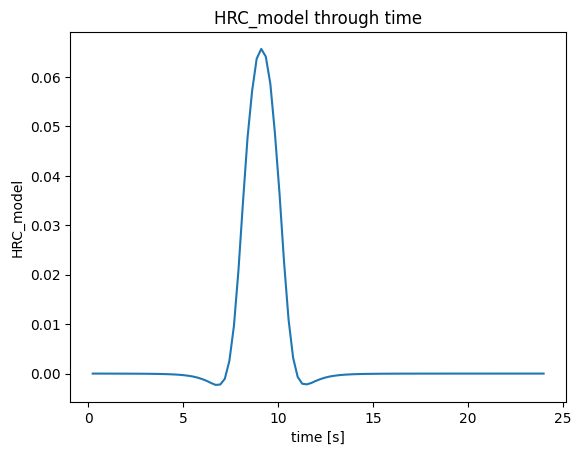

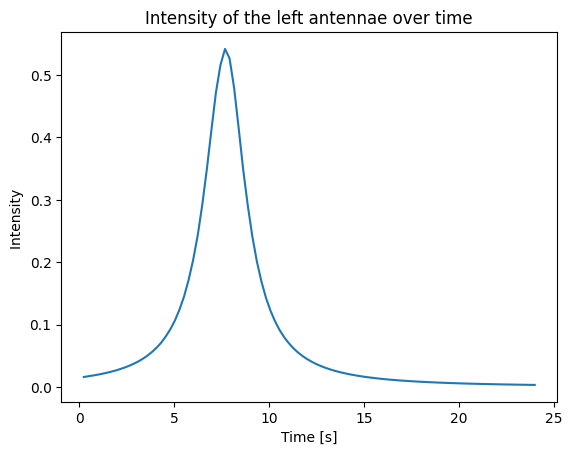

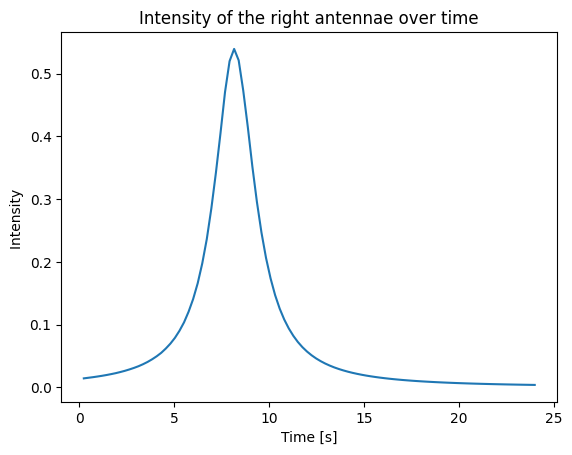

In [12]:

plt.plot(x,HRC_model)
 #change the values of the xlabel

plt.xlabel('time [s]')
plt.ylabel('HRC_model')
plt.title('HRC_model through time')
plt.savefig("./outputs/outputs_finaux/HRC_exp_A_1_2.png")
plt.show()

#HRC_model

# Extract the first column from odor_history
first_column = [entry[0] for entry in odor_history]

# Plot the first column
plt.plot(x,first_column)
plt.xlabel('Time [s]')
plt.ylabel('Intensity ')
plt.title('Intensity of the left antennae over time')
plt.savefig("./outputs/outputs_finaux/antenne_1_exp_A_1_2.png")
plt.show()

# Extract the second column from odor_history
second_column = [entry[1] for entry in odor_history]

# Plot the second column
plt.plot(x,second_column)
plt.xlabel('Time [s]')
plt.ylabel('Intensity ')
plt.title('Intensity of the right antennae over time')
plt.savefig("./outputs/outputs_finaux/antenne_2_exp_A_1_2.png")
plt.show()